### importing modules

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 15

In [4]:
import numpy as np
import gym
from collections import deque
import random
import pickle
import time
import copy

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


## class for DQN

In [86]:
class DQN:
    
    def __init__(self, o_space, a_space, lr, units=32, mem_len=10000):
        self.a_space = a_space
        self.state_size = o_space

        self.lr = lr
        self.units = units
        
        # hyperparameters
        self.discount = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 50
        self.train_start = 1000
        self.memory = deque(maxlen=10000)

        # create main model and target model
        self.model = self.init_model()
        self.target_model = self.init_model()

        # initialize target model
        self.update_target_model()

    def init_model(self):
        model = Sequential()
        model.add(Dense(self.units, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.units, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.a_space, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, s):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.a_space)
        else:
            q_value = self.model.predict(s)
            return np.argmax(q_value[0])

    def add_experience(self, s, a, r, s_next, terminal):
        self.memory.append([s, a, r, s_next, terminal])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
      
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        a, r, terminal = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            a.append(mini_batch[i][1])
            r.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            if terminal[i]:
                target[i][a[i]] = r[i]
            else:
                target[i][a[i]] = r[i] + self.discount * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 

In [87]:
terminal_r_dict = {
    'CartPole-v1': -1.0,
    'LunarLander-v2': 100.0,
    'MountainCar-v0': 1.0
}

memory_env = {
    'CartPole-v1': 10000,
    'LunarLander-v2': 10000,
    'MountainCar-v0': 10000
}

In [88]:
class DQN_HER:
    
    def __init__(self, o_space, a_space, lr, units=32, mem_len=10000):
        self.a_space = a_space
        self.state_size = o_space

        self.lr = lr
        self.units = units
        # hyperparameters
        self.discount = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 50
        self.train_start = 1000
        self.memory = deque(maxlen=mem_len)
        self.her_memory = deque(maxlen=1000)

        # create main model and target model
        self.model = self.init_model()
        self.target_model = self.init_model()

        # initialize target model
        self.update_target_model()

    def init_model(self):
        model = Sequential()
        model.add(Dense(self.units, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.units, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.a_space, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, s):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.a_space)
        else:
            q_value = self.model.predict(s)
            return np.argmax(q_value[0])

    def add_experience(self, s, a, r, s_next, terminal):
        self.memory.append([s, a, r, s_next, terminal])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def add_her_experience(self, s, a, r, s_next, terminal):
        self.her_memory.append([s, a, r, s_next, terminal])
        
    def modify_her_list(self, terminal_reward):
        new_her_experience = copy.deepcopy(self.her_memory)
        new_her_len = len(new_her_experience)
        her_goal = self.her_memory[-1][3]
        
        for i in range(new_her_len):
            new_her_experience[-1-i][0] = her_goal
            new_her_experience[-1-i][2] = self.memory[-1-i][2]
            new_her_experience[-1-i][3] = her_goal
            new_her_experience[-1-i][4] = False
            
            if (np.sum(np.abs((new_her_experience[-1-i][3] - her_goal))) == 0):
                new_her_experience[-1-i][2] = terminal_reward
                new_her_experience[-1-i][4] = True
        
        for hx in new_her_experience:
            self.memory.append(hx)
            
        self.reset_her()
            
    def reset_her(self):
        self.her_memory.clear()
      
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        a, r, terminal = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            a.append(mini_batch[i][1])
            r.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            if terminal[i]:
                target[i][a[i]] = r[i]
            else:
                target[i][a[i]] = r[i] + self.discount * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 

## main

#### settings

In [96]:
num_seeds = 5
seeds = np.arange(num_seeds)
num_episodes = 10

### classic replay

In [94]:
result_dict = {}

env_name = 'CartPole-v1'

for seed in seeds:
    if seed not in result_dict.keys():
        result_dict[seed] = []
    
    env = gym.make(env_name)
    
    np.random.seed(seed)
    env.action_space.np_random.seed(seed)
    
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n
    agent = DQN(o_space, a_space, lr)
    
    scores, episodes = [], []
    
    for num_episode in range(num_episodes):
        terminal = False
        score = 0
        s = env.reset()
        s = np.reshape(s, [1, o_space])

        while not terminal:

            a = agent.get_action(s)
            s_next, r, terminal, _ = env.step(a)
            s_next = np.reshape(s_next, [1, o_space])

            # if an action make the episode end, then gives penalty of -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.add_experience(s, a, r, s_next, terminal)
            # every time step do the training
            agent.train_model()
            score += r
            s = s_next

            if terminal:
                agent.update_target_model()

                scores.append(score)
                episodes.append(num_episode)
                print("episode:", num_episode, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
    
    result_dict[seed] = scores
        
print(result_dict)

episode: 0   score: 34.0   memory length: 34   epsilon: 0.9665550620990835
episode: 1   score: 16.0   memory length: 50   epsilon: 0.9512056281970315
episode: 2   score: 20.0   memory length: 70   epsilon: 0.9323611649219127
episode: 3   score: 20.0   memory length: 90   epsilon: 0.9138900318559524
episode: 4   score: 10.0   memory length: 100   epsilon: 0.9047921471137096
episode: 5   score: 14.0   memory length: 114   epsilon: 0.8922070646990518
episode: 6   score: 38.0   memory length: 152   epsilon: 0.8589229565610536
episode: 7   score: 11.0   memory length: 163   epsilon: 0.8495219033622532
episode: 8   score: 22.0   memory length: 185   epsilon: 0.8310273589761736
episode: 9   score: 20.0   memory length: 205   epsilon: 0.8145637636371417
episode: 0   score: 21.0   memory length: 21   epsilon: 0.9792086759647052
episode: 1   score: 36.0   memory length: 57   epsilon: 0.9445671308589195
episode: 2   score: 10.0   memory length: 67   epsilon: 0.9351638519212846
episode: 3   score:

In [97]:
result_dict = {}

env_name = 'MountainCar-v0'

for seed in seeds:
    if seed not in result_dict.keys():
        result_dict[seed] = []
    
    env = gym.make(env_name)
    
    np.random.seed(seed)
    env.action_space.np_random.seed(seed)
    
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n
    agent = DQN(o_space, a_space, lr)
    
    scores, episodes = [], []
    
    for num_episode in range(num_episodes):
        terminal = False
        score = 0
        s = env.reset()
        s = np.reshape(s, [1, o_space])

        while not terminal:

            a = agent.get_action(s)
            s_next, r, terminal, _ = env.step(a)
            s_next = np.reshape(s_next, [1, o_space])

            # if an action make the episode end, then gives penalty of -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.add_experience(s, a, r, s_next, terminal)
            # every time step do the training
            agent.train_model()
            score += r
            s = s_next

            if terminal:
                agent.update_target_model()

                scores.append(score)
                episodes.append(num_episode)
                print("episode:", num_episode, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
    
    result_dict[seed] = scores
        
print(result_dict)

episode: 0   score: -200.0   memory length: 200   epsilon: 0.818648829478636
episode: 1   score: -200.0   memory length: 400   epsilon: 0.6701859060067403
episode: 2   score: -200.0   memory length: 600   epsilon: 0.5486469074854965
episode: 3   score: -200.0   memory length: 800   epsilon: 0.4491491486100748
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.3676954247709635
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.3010134290933992
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.24642429138466176
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.20173495769715546
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.1651500869836984
episode: 9   score: -200.0   memory length: 2000   epsilon: 0.1351999253974994
episode: 0   score: -200.0   memory length: 200   epsilon: 0.818648829478636
episode: 1   score: -200.0   memory length: 400   epsilon: 0.6701859060067403
episode: 2   score: -200.0   memory length: 600   epsilon:

In [98]:
result_dict = {}

env_name = 'LunarLander-v2'

for seed in seeds:
    if seed not in result_dict.keys():
        result_dict[seed] = []
    
    env = gym.make(env_name)
    
    np.random.seed(seed)
    env.action_space.np_random.seed(seed)
    
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n
    agent = DQN(o_space, a_space, lr)
    
    scores, episodes = [], []
    
    for num_episode in range(num_episodes):
        terminal = False
        score = 0
        s = env.reset()
        s = np.reshape(s, [1, o_space])

        while not terminal:

            a = agent.get_action(s)
            s_next, r, terminal, _ = env.step(a)
            s_next = np.reshape(s_next, [1, o_space])

            # if an action make the episode end, then gives penalty of -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.add_experience(s, a, r, s_next, terminal)
            # every time step do the training
            agent.train_model()
            score += r
            s = s_next

            if terminal:
                agent.update_target_model()

                scores.append(score)
                episodes.append(num_episode)
                print("episode:", num_episode, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
    
    result_dict[seed] = scores
        
print(result_dict)

episode: 0   score: -77.9620860900572   memory length: 62   epsilon: 0.9398537314349842
episode: 1   score: -82.51096653685944   memory length: 122   epsilon: 0.88509434007808
episode: 2   score: 1.2753196821610118   memory length: 207   epsilon: 0.812935450673631
episode: 3   score: -227.00319988184683   memory length: 300   epsilon: 0.7407070321560997
episode: 4   score: -301.83795564016515   memory length: 381   epsilon: 0.6830476698153162
episode: 5   score: -593.1120998199466   memory length: 475   epsilon: 0.6217372777861888
episode: 6   score: -559.5246397837104   memory length: 547   epsilon: 0.5785249048906184
episode: 7   score: -448.6371219669424   memory length: 635   epsilon: 0.5297671482893791
episode: 8   score: -283.1466026806963   memory length: 698   epsilon: 0.4974057274803321
episode: 9   score: -380.87801445564713   memory length: 771   epsilon: 0.46237188898344517
episode: 0   score: -127.41148044459575   memory length: 86   epsilon: 0.9175547491935327
episode: 1 

### HER

In [ ]:
result_dict = {}

env_name = 'CartPole-v1'

for seed in seeds:
    if seed not in result_dict.keys():
        result_dict[seed] = []
    
    env = gym.make(env_name)
    
    np.random.seed(seed)
    env.action_space.np_random.seed(seed)
    
    o_space = env.observation_space.shape[0]
    a_space = env.action_space.n
    agent = DQN(o_space, a_space, lr)
    
    scores, episodes = [], []
    
    for num_episode in range(num_episodes):
        terminal = False
        score = 0
        s = env.reset()
        s = np.reshape(s, [1, o_space])

        while not terminal:

            a = agent.get_action(s)
            s_next, r, terminal, _ = env.step(a)
            s_next = np.reshape(s_next, [1, o_space])

            # if an action make the episode end, then gives penalty of -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.add_experience(s, a, r, s_next, terminal)
            # every time step do the training
            agent.train_model()
            score += r
            s = s_next

            if terminal:
                agent.update_target_model()

                scores.append(score)
                episodes.append(num_episode)
                print("episode:", num_episode, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
    
    result_dict[seed] = scores
        
print(result_dict)

In [42]:
# cartpole classic

In [36]:
%%time

env = gym.make('CartPole-v1')
max_episodes = 300
lr=0.001

seed=0
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# env.seed(seed)
# env.action_space.np_random.seed(seed)

# eps_steps = []

o_space = env.observation_space.shape[0]
a_space = env.action_space.n
agent = DQN(o_space, a_space, lr)

scores, episodes = [], []

for num_episode in range(1, max_episodes+1):
    terminal = False
    score = 0
    # start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    while not terminal:

        a = agent.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        # if an action make the episode end, then gives penalty of -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.add_experience(s, a, r, s_next, terminal)
        # every time step do the training
        agent.train_model()
        score += r
        s = s_next

        if terminal:
            agent.update_target_model()

            scores.append(score)
            episodes.append(num_episode)
            print("episode:", num_episode, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

episode: 1   score: 37.0   memory length: 37   epsilon: 0.9636582956114175
episode: 2   score: 25.0   memory length: 62   epsilon: 0.9398537314349842
episode: 3   score: 16.0   memory length: 78   epsilon: 0.9249283295681431
episode: 4   score: 21.0   memory length: 99   epsilon: 0.9056978449586682
episode: 5   score: 16.0   memory length: 115   epsilon: 0.8913148576343527
episode: 6   score: 24.0   memory length: 139   epsilon: 0.8701675093639105
episode: 7   score: 15.0   memory length: 154   epsilon: 0.857205969570888
episode: 8   score: 15.0   memory length: 169   epsilon: 0.8444374977929298
episode: 9   score: 16.0   memory length: 185   epsilon: 0.8310273589761736
episode: 10   score: 26.0   memory length: 211   epsilon: 0.8096885832327116
episode: 11   score: 22.0   memory length: 233   epsilon: 0.7920612314455105
episode: 12   score: 36.0   memory length: 269   epsilon: 0.7640404167313927
episode: 13   score: 14.0   memory length: 283   epsilon: 0.7534131012276413
episode: 14  

episode: 108   score: 11.0   memory length: 1568   epsilon: 0.20829821022248174
episode: 109   score: 12.0   memory length: 1580   epsilon: 0.20581233365902327
episode: 110   score: 11.0   memory length: 1591   epsilon: 0.2035596837759133
episode: 111   score: 10.0   memory length: 1601   epsilon: 0.2015332227394583
episode: 112   score: 12.0   memory length: 1613   epsilon: 0.19912808102157614
episode: 113   score: 9.0   memory length: 1622   epsilon: 0.197343080201605
episode: 114   score: 11.0   memory length: 1633   epsilon: 0.19518312769222232
episode: 115   score: 9.0   memory length: 1642   epsilon: 0.193433489764775
episode: 116   score: 11.0   memory length: 1653   epsilon: 0.1913163283665175
episode: 117   score: 10.0   memory length: 1663   epsilon: 0.18941175139979763
episode: 118   score: 9.0   memory length: 1672   epsilon: 0.1877138485735047
episode: 119   score: 8.0   memory length: 1680   epsilon: 0.1862173832738307
episode: 120   score: 10.0   memory length: 1690   ep

episode: 209   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 210   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 211   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 212   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 213   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 214   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 215   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 216   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 217   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 218   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 219   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 220   score: 500.0   memory length: 10000   epsilon: 0.009998671593271896
epis

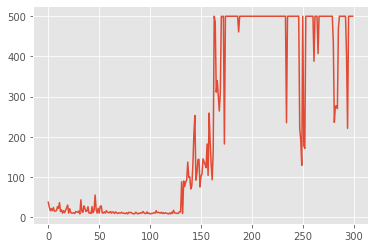

In [38]:
plt.plot(scores)

In [58]:
# mountaincar classic

In [67]:
%%time

env_name = "MountainCar-v0"
env = gym.make(env_name)
max_episodes = 300
lr=0.001

seed=0

o_space = env.observation_space.shape[0]
a_space = env.action_space.n
agent = DQN(o_space, a_space, lr)

scores, episodes = [], []

for num_episode in range(1, max_episodes+1):
    terminal = False
    score = 0
    # start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    while not terminal:

        a = agent.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        # if an action make the episode end, then gives penalty of -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.add_experience(s, a, r, s_next, terminal)
#         agent.add_her_experience(s, a, r, s_next, terminal)
        # every time step do the training
#         agent.modify_her_list(terminal_reward=terminal_r_dict[env_name])
        agent.train_model()
        score += r
        s = s_next

        if terminal:
            agent.update_target_model()

            scores.append(score)
            episodes.append(num_episode)
            print("episode:", num_episode, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

episode: 1   score: -200.0   memory length: 200   epsilon: 0.818648829478636
episode: 2   score: -200.0   memory length: 400   epsilon: 0.6701859060067403
episode: 3   score: -200.0   memory length: 600   epsilon: 0.5486469074854965
episode: 4   score: -200.0   memory length: 800   epsilon: 0.4491491486100748
episode: 5   score: -200.0   memory length: 1000   epsilon: 0.3676954247709635
episode: 6   score: -200.0   memory length: 1200   epsilon: 0.3010134290933992
episode: 7   score: -200.0   memory length: 1400   epsilon: 0.24642429138466176
episode: 8   score: -200.0   memory length: 1600   epsilon: 0.20173495769715546
episode: 9   score: -200.0   memory length: 1800   epsilon: 0.1651500869836984
episode: 10   score: -200.0   memory length: 2000   epsilon: 0.1351999253974994
episode: 11   score: -200.0   memory length: 2200   epsilon: 0.11068126067226178
episode: 12   score: -200.0   memory length: 2400   epsilon: 0.09060908449456685
episode: 13   score: -200.0   memory length: 2600 

KeyboardInterrupt: 

In [ ]:
# mountaincar her

In [77]:
%%time

env_name = "MountainCar-v0"
env = gym.make(env_name)
max_episodes = 300
lr=0.001

seed=0

o_space = env.observation_space.shape[0]
a_space = env.action_space.n
agent = DQN_HER(o_space, a_space, lr)

scores, episodes = [], []

for num_episode in range(1, max_episodes+1):
    terminal = False
    score = 0
    # start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    while not terminal:

        a = agent.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        # if an action make the episode end, then gives penalty of -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.add_experience(s, a, r, s_next, terminal)
        agent.add_her_experience(s, a, r, s_next, terminal)
        # every time step do the training
        agent.modify_her_list(terminal_reward=terminal_r_dict[env_name])
        agent.train_model()
        score += r
        s = s_next

        if terminal:
            agent.update_target_model()

            scores.append(score)
            episodes.append(num_episode)
            print("episode:", num_episode, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

episode: 1   score: -200.0   memory length: 400   epsilon: 0.818648829478636
episode: 2   score: -200.0   memory length: 800   epsilon: 0.6701859060067403
episode: 3   score: -200.0   memory length: 1200   epsilon: 0.5486469074854965
episode: 4   score: -200.0   memory length: 1600   epsilon: 0.4491491486100748
episode: 5   score: -200.0   memory length: 2000   epsilon: 0.3676954247709635
episode: 6   score: -200.0   memory length: 2400   epsilon: 0.3010134290933992
episode: 7   score: -200.0   memory length: 2800   epsilon: 0.24642429138466176
episode: 8   score: -200.0   memory length: 3200   epsilon: 0.20173495769715546
episode: 9   score: -200.0   memory length: 3600   epsilon: 0.1651500869836984
episode: 10   score: -200.0   memory length: 4000   epsilon: 0.1351999253974994
episode: 11   score: -200.0   memory length: 4400   epsilon: 0.11068126067226178
episode: 12   score: -200.0   memory length: 4800   epsilon: 0.09060908449456685
episode: 13   score: -200.0   memory length: 520

episode: 101   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 102   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 104   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 105   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.00999867159

KeyboardInterrupt: 

In [ ]:
# mountaincar classic

In [39]:
%%time

env = gym.make('MountainCar-v0')
max_episodes = 300
lr=0.001

seed=0

o_space = env.observation_space.shape[0]
a_space = env.action_space.n
agent = DQN(o_space, a_space, lr)

scores, episodes = [], []

for num_episode in range(1, max_episodes+1):
    terminal = False
    score = 0
    # start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    while not terminal:

        a = agent.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        # if an action make the episode end, then gives penalty of -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.add_experience(s, a, r, s_next, terminal)
        # every time step do the training
        agent.train_model()
        score += r
        s = s_next

        if terminal:
            agent.update_target_model()

            scores.append(score)
            episodes.append(num_episode)
            print("episode:", num_episode, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

episode: 1   score: -200.0   memory length: 200   epsilon: 0.818648829478636
episode: 2   score: -200.0   memory length: 400   epsilon: 0.6701859060067403
episode: 3   score: -200.0   memory length: 600   epsilon: 0.5486469074854965
episode: 4   score: -200.0   memory length: 800   epsilon: 0.4491491486100748
episode: 5   score: -200.0   memory length: 1000   epsilon: 0.3676954247709635
episode: 6   score: -200.0   memory length: 1200   epsilon: 0.3010134290933992
episode: 7   score: -200.0   memory length: 1400   epsilon: 0.24642429138466176
episode: 8   score: -200.0   memory length: 1600   epsilon: 0.20173495769715546
episode: 9   score: -200.0   memory length: 1800   epsilon: 0.1651500869836984
episode: 10   score: -200.0   memory length: 2000   epsilon: 0.1351999253974994
episode: 11   score: -200.0   memory length: 2200   epsilon: 0.11068126067226178
episode: 12   score: -200.0   memory length: 2400   epsilon: 0.09060908449456685
episode: 13   score: -200.0   memory length: 2600 

episode: 101   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 102   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 103   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 104   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 105   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 106   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 107   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 108   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 109   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 110   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 111   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 112   score: -200.0   memory length: 10000   epsilon: 0.00999867159

episode: 199   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 200   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 201   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 202   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 203   score: -199.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 204   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 205   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 206   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 207   score: -172.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 208   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 209   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 210   score: -200.0   memory length: 10000   epsilon: 0.00999867159

episode: 297   score: -200.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 298   score: -166.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 299   score: -156.0   memory length: 10000   epsilon: 0.009998671593271896
episode: 300   score: -198.0   memory length: 10000   epsilon: 0.009998671593271896
CPU times: user 4min 58s, sys: 53.4 s, total: 5min 51s
Wall time: 4min 6s


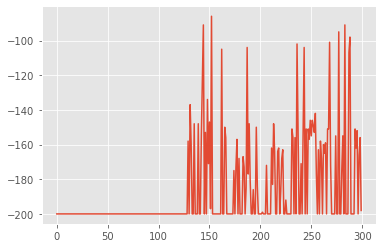

In [40]:
plt.plot(scores)

In [25]:
env = gym.make('LunarLander-v2')
max_episodes = 300
lr=0.001

seed=0
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# env.seed(seed)
# env.action_space.np_random.seed(seed)

# eps_steps = []

o_space = env.observation_space.shape[0]
a_space = env.action_space.n
agent = DQN(o_space, a_space, lr)

scores, episodes = [], []

for num_episode in range(1, max_episodes+1):
    terminal = False
    score = 0
    # start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    while not terminal:

        a = agent.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        # if an action make the episode end, then gives penalty of -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.add_experience(s, a, r, s_next, terminal)
        # every time step do the training
        agent.train_model()
        score += r
        s = s_next

        if terminal:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(num_episode)
            # pylab.plot(episodes, scores, 'b')
            # pylab.savefig("./save_graph/cartpole_dqn.png")
            print("episode:", num_episode, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

end = time.time()
elapsed = end - start


episode: 1   score: -221.07055716045505   memory length: 68   epsilon: 0.9342286880693633
episode: 2   score: -414.5613581820328   memory length: 163   epsilon: 0.8495219033622532
episode: 3   score: -319.37268460458097   memory length: 248   epsilon: 0.7802631200940584
episode: 4   score: -129.8783673646824   memory length: 334   epsilon: 0.7159341314628666
episode: 5   score: -100.47049013119019   memory length: 470   epsilon: 0.6248553120386914
episode: 6   score: -393.0194330114719   memory length: 560   epsilon: 0.5710490410244006
episode: 7   score: -383.5756081136802   memory length: 639   epsilon: 0.5276512561805725
episode: 8   score: -220.52353180460366   memory length: 807   epsilon: 0.44601452099741573
episode: 9   score: -399.406404707456   memory length: 956   epsilon: 0.3842436897667367
episode: 10   score: -455.14571449644905   memory length: 1075   epsilon: 0.34111423472584396
episode: 11   score: -149.77917276426757   memory length: 1153   epsilon: 0.3155062193168902


episode: 88   score: -74.99526945958432   memory length: 10000   epsilon: 0.009998671593271896
episode: 89   score: -128.27960139082592   memory length: 10000   epsilon: 0.009998671593271896
episode: 90   score: -73.8812290213444   memory length: 10000   epsilon: 0.009998671593271896
episode: 91   score: -98.68731448884095   memory length: 10000   epsilon: 0.009998671593271896
episode: 92   score: -90.2000872690109   memory length: 10000   epsilon: 0.009998671593271896
episode: 93   score: -140.56620710453006   memory length: 10000   epsilon: 0.009998671593271896
episode: 94   score: -174.38884778812073   memory length: 10000   epsilon: 0.009998671593271896
episode: 95   score: -119.07657074573726   memory length: 10000   epsilon: 0.009998671593271896
episode: 96   score: -175.29890052246566   memory length: 10000   epsilon: 0.009998671593271896
episode: 97   score: -163.6389306874988   memory length: 10000   epsilon: 0.009998671593271896
episode: 98   score: -87.13505645157966   memor

episode: 174   score: -121.78508410505145   memory length: 10000   epsilon: 0.009998671593271896
episode: 175   score: -119.56263837036417   memory length: 10000   epsilon: 0.009998671593271896
episode: 176   score: -64.12447733434317   memory length: 10000   epsilon: 0.009998671593271896
episode: 177   score: -129.38898570726852   memory length: 10000   epsilon: 0.009998671593271896
episode: 178   score: -59.07068711850041   memory length: 10000   epsilon: 0.009998671593271896
episode: 179   score: -135.12936595385625   memory length: 10000   epsilon: 0.009998671593271896
episode: 180   score: -108.24425914739899   memory length: 10000   epsilon: 0.009998671593271896
episode: 181   score: -43.385636075069954   memory length: 10000   epsilon: 0.009998671593271896
episode: 182   score: -54.79914618342801   memory length: 10000   epsilon: 0.009998671593271896
episode: 183   score: -25.77610763782542   memory length: 10000   epsilon: 0.009998671593271896
episode: 184   score: -134.5796875

KeyboardInterrupt: 

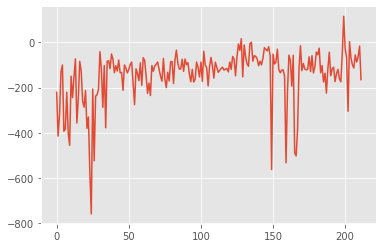

In [26]:
plt.plot(scores)

### main

In [212]:
# learning_rates = [0.5, 0.1, 0.01, 0.001, 0.0001]
# buffers = [50, 100, 250, 500]
# methods = ['sarsa', 'exp_sarsa', 'q']
# seeds = np.arange(20)

# max_episodes = 100

# more doable (recommended by Veronica)

learning_rates = [0.1, 0.01, 0.001]
buffers = [50, 100, 250, 500]
methods = ['sarsa', 'exp_sarsa', 'q']
seeds = np.arange(5)
max_episodes = 100

# learning_rates = [0.1, 0.01, 0.001]
# learning_rates = [0.1, 0.01]
# buffers = [50]
# methods = ['exp_sarsa']
# seeds = np.arange(1)

# max_episodes = 25

In [213]:
# default values to start off with

buffer = 50
lr = 0.001
seed = 0
max_episodes = 1000

In [225]:
terminal_r_dict = {
    'CartPole-v1': -1.0,
    'LunarLander-v2': 100.0,
    'Centipede-ram-v0': 0.0
}

### cartpole HER

In [229]:
%%time

print(buffer, lr, seed)
np.random.seed(seed)

env_name = 'CartPole-v1'

eps_steps = []
env = gym.make(env_name)

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_HER(terminal_reward=terminal_r_dict[env_name], buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    replay.reset_her()

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
            
#         print(r)
        
        replay.add_experience(s, a, r, s_next, terminal)
        replay.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    replay.modify_her_list()
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.001 0
num_episode: 1; terminal_step: 39
num_episode: 2; terminal_step: 58
num_episode: 3; terminal_step: 63
num_episode: 4; terminal_step: 51
num_episode: 5; terminal_step: 99
num_episode: 6; terminal_step: 79
num_episode: 7; terminal_step: 73
num_episode: 8; terminal_step: 47
num_episode: 9; terminal_step: 32
num_episode: 10; terminal_step: 71
num_episode: 11; terminal_step: 39
num_episode: 12; terminal_step: 113
num_episode: 13; terminal_step: 37
num_episode: 14; terminal_step: 67
num_episode: 15; terminal_step: 112
num_episode: 16; terminal_step: 101
num_episode: 17; terminal_step: 64
num_episode: 18; terminal_step: 61
num_episode: 19; terminal_step: 62
num_episode: 20; terminal_step: 170
num_episode: 21; terminal_step: 38
num_episode: 22; terminal_step: 85
num_episode: 23; terminal_step: 158
num_episode: 24; terminal_step: 49
num_episode: 25; terminal_step: 47
num_episode: 26; terminal_step: 51
num_episode: 27; terminal_step: 34
num_episode: 28; terminal_step: 120
num_episode:

num_episode: 231; terminal_step: 27
num_episode: 232; terminal_step: 42
num_episode: 233; terminal_step: 63
num_episode: 234; terminal_step: 62
num_episode: 235; terminal_step: 118
num_episode: 236; terminal_step: 107
num_episode: 237; terminal_step: 51
num_episode: 238; terminal_step: 83
num_episode: 239; terminal_step: 95
num_episode: 240; terminal_step: 67
num_episode: 241; terminal_step: 43
num_episode: 242; terminal_step: 69
num_episode: 243; terminal_step: 105
num_episode: 244; terminal_step: 90
num_episode: 245; terminal_step: 54
num_episode: 246; terminal_step: 43
num_episode: 247; terminal_step: 129
num_episode: 248; terminal_step: 55
num_episode: 249; terminal_step: 122
num_episode: 250; terminal_step: 48
num_episode: 251; terminal_step: 109
num_episode: 252; terminal_step: 79
num_episode: 253; terminal_step: 35
num_episode: 254; terminal_step: 34
num_episode: 255; terminal_step: 30
num_episode: 256; terminal_step: 60
num_episode: 257; terminal_step: 56
num_episode: 258; term

num_episode: 459; terminal_step: 40
num_episode: 460; terminal_step: 40
num_episode: 461; terminal_step: 44
num_episode: 462; terminal_step: 44
num_episode: 463; terminal_step: 40
num_episode: 464; terminal_step: 36
num_episode: 465; terminal_step: 46
num_episode: 466; terminal_step: 28
num_episode: 467; terminal_step: 27
num_episode: 468; terminal_step: 32
num_episode: 469; terminal_step: 34
num_episode: 470; terminal_step: 38
num_episode: 471; terminal_step: 36
num_episode: 472; terminal_step: 33
num_episode: 473; terminal_step: 47
num_episode: 474; terminal_step: 64
num_episode: 475; terminal_step: 44
num_episode: 476; terminal_step: 68
num_episode: 477; terminal_step: 64
num_episode: 478; terminal_step: 48
num_episode: 479; terminal_step: 72
num_episode: 480; terminal_step: 83
num_episode: 481; terminal_step: 52
num_episode: 482; terminal_step: 39
num_episode: 483; terminal_step: 45
num_episode: 484; terminal_step: 45
num_episode: 485; terminal_step: 41
num_episode: 486; terminal_s

num_episode: 683; terminal_step: 227
num_episode: 684; terminal_step: 133
num_episode: 685; terminal_step: 150
num_episode: 686; terminal_step: 345
num_episode: 687; terminal_step: 113
num_episode: 688; terminal_step: 175
num_episode: 689; terminal_step: 202
num_episode: 690; terminal_step: 101
num_episode: 691; terminal_step: 88
num_episode: 692; terminal_step: 75
num_episode: 693; terminal_step: 149
num_episode: 694; terminal_step: 191
num_episode: 695; terminal_step: 179
num_episode: 696; terminal_step: 141
num_episode: 697; terminal_step: 248
num_episode: 698; terminal_step: 459
num_episode: 699; terminal_step: 203
num_episode: 700; terminal_step: 500
num_episode: 701; terminal_step: 500
num_episode: 702; terminal_step: 352
num_episode: 703; terminal_step: 414
num_episode: 704; terminal_step: 394
num_episode: 705; terminal_step: 141
num_episode: 706; terminal_step: 286
num_episode: 707; terminal_step: 156
num_episode: 708; terminal_step: 244
num_episode: 709; terminal_step: 156
num

num_episode: 905; terminal_step: 448
num_episode: 906; terminal_step: 307
num_episode: 907; terminal_step: 374
num_episode: 908; terminal_step: 258
num_episode: 909; terminal_step: 295
num_episode: 910; terminal_step: 307
num_episode: 911; terminal_step: 200
num_episode: 912; terminal_step: 187
num_episode: 913; terminal_step: 280
num_episode: 914; terminal_step: 462
num_episode: 915; terminal_step: 408
num_episode: 916; terminal_step: 186
num_episode: 917; terminal_step: 340
num_episode: 918; terminal_step: 500
num_episode: 919; terminal_step: 500
num_episode: 920; terminal_step: 374
num_episode: 921; terminal_step: 500
num_episode: 922; terminal_step: 428
num_episode: 923; terminal_step: 500
num_episode: 924; terminal_step: 500
num_episode: 925; terminal_step: 500
num_episode: 926; terminal_step: 500
num_episode: 927; terminal_step: 498
num_episode: 928; terminal_step: 279
num_episode: 929; terminal_step: 219
num_episode: 930; terminal_step: 330
num_episode: 931; terminal_step: 385
n

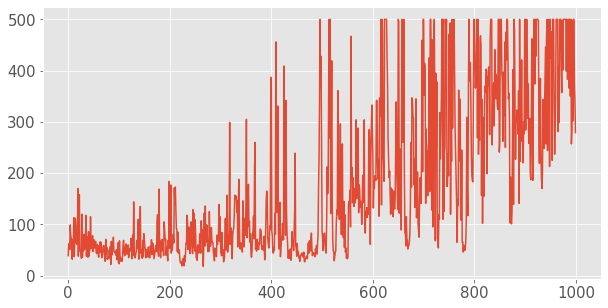

In [230]:
plt.plot(eps_steps)

### cartpole default replay

In [254]:
%%time

buffer = 50
print(buffer, lr, seed)
np.random.seed(seed)

env_name = 'CartPole-v1'

eps_steps = []
env = gym.make(env_name)

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -100
        else:
            r = r
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.001 0
num_episode: 1; terminal_step: 63
num_episode: 2; terminal_step: 24
num_episode: 3; terminal_step: 56
num_episode: 4; terminal_step: 55
num_episode: 5; terminal_step: 21
num_episode: 6; terminal_step: 98
num_episode: 7; terminal_step: 32
num_episode: 8; terminal_step: 42
num_episode: 9; terminal_step: 62
num_episode: 10; terminal_step: 21
num_episode: 11; terminal_step: 41
num_episode: 12; terminal_step: 57
num_episode: 13; terminal_step: 43
num_episode: 14; terminal_step: 31
num_episode: 15; terminal_step: 44
num_episode: 16; terminal_step: 25
num_episode: 17; terminal_step: 31
num_episode: 18; terminal_step: 52
num_episode: 19; terminal_step: 27
num_episode: 20; terminal_step: 21
num_episode: 21; terminal_step: 74
num_episode: 22; terminal_step: 34
num_episode: 23; terminal_step: 47
num_episode: 24; terminal_step: 41
num_episode: 25; terminal_step: 49
num_episode: 26; terminal_step: 31
num_episode: 27; terminal_step: 31
num_episode: 28; terminal_step: 41
num_episode: 29; t

num_episode: 232; terminal_step: 43
num_episode: 233; terminal_step: 42
num_episode: 234; terminal_step: 45
num_episode: 235; terminal_step: 46
num_episode: 236; terminal_step: 45
num_episode: 237; terminal_step: 37
num_episode: 238; terminal_step: 62
num_episode: 239; terminal_step: 197
num_episode: 240; terminal_step: 48
num_episode: 241; terminal_step: 63
num_episode: 242; terminal_step: 60
num_episode: 243; terminal_step: 49
num_episode: 244; terminal_step: 51
num_episode: 245; terminal_step: 56
num_episode: 246; terminal_step: 54
num_episode: 247; terminal_step: 74
num_episode: 248; terminal_step: 51
num_episode: 249; terminal_step: 56
num_episode: 250; terminal_step: 52
num_episode: 251; terminal_step: 69
num_episode: 252; terminal_step: 80
num_episode: 253; terminal_step: 65
num_episode: 254; terminal_step: 59
num_episode: 255; terminal_step: 63
num_episode: 256; terminal_step: 78
num_episode: 257; terminal_step: 46
num_episode: 258; terminal_step: 44
num_episode: 259; terminal_

num_episode: 458; terminal_step: 500
num_episode: 459; terminal_step: 500
num_episode: 460; terminal_step: 500
num_episode: 461; terminal_step: 500
num_episode: 462; terminal_step: 500
num_episode: 463; terminal_step: 500
num_episode: 464; terminal_step: 500
num_episode: 465; terminal_step: 500
num_episode: 466; terminal_step: 370
num_episode: 467; terminal_step: 500
num_episode: 468; terminal_step: 500
num_episode: 469; terminal_step: 500
num_episode: 470; terminal_step: 500
num_episode: 471; terminal_step: 500
num_episode: 472; terminal_step: 500
num_episode: 473; terminal_step: 500
num_episode: 474; terminal_step: 500
num_episode: 475; terminal_step: 500
num_episode: 476; terminal_step: 500
num_episode: 477; terminal_step: 500
num_episode: 478; terminal_step: 500
num_episode: 479; terminal_step: 500
num_episode: 480; terminal_step: 500
num_episode: 481; terminal_step: 500
num_episode: 482; terminal_step: 500
num_episode: 483; terminal_step: 500
num_episode: 484; terminal_step: 500
n

num_episode: 680; terminal_step: 305
num_episode: 681; terminal_step: 267
num_episode: 682; terminal_step: 372
num_episode: 683; terminal_step: 386
num_episode: 684; terminal_step: 500
num_episode: 685; terminal_step: 500
num_episode: 686; terminal_step: 500
num_episode: 687; terminal_step: 500
num_episode: 688; terminal_step: 500
num_episode: 689; terminal_step: 500
num_episode: 690; terminal_step: 500
num_episode: 691; terminal_step: 500
num_episode: 692; terminal_step: 500
num_episode: 693; terminal_step: 395
num_episode: 694; terminal_step: 500
num_episode: 695; terminal_step: 421
num_episode: 696; terminal_step: 362
num_episode: 697; terminal_step: 455
num_episode: 698; terminal_step: 370
num_episode: 699; terminal_step: 432
num_episode: 700; terminal_step: 500
num_episode: 701; terminal_step: 500
num_episode: 702; terminal_step: 500
num_episode: 703; terminal_step: 500
num_episode: 704; terminal_step: 500
num_episode: 705; terminal_step: 500
num_episode: 706; terminal_step: 440
n

num_episode: 902; terminal_step: 500
num_episode: 903; terminal_step: 500
num_episode: 904; terminal_step: 500
num_episode: 905; terminal_step: 500
num_episode: 906; terminal_step: 500
num_episode: 907; terminal_step: 500
num_episode: 908; terminal_step: 500
num_episode: 909; terminal_step: 500
num_episode: 910; terminal_step: 500
num_episode: 911; terminal_step: 500
num_episode: 912; terminal_step: 500
num_episode: 913; terminal_step: 500
num_episode: 914; terminal_step: 500
num_episode: 915; terminal_step: 500
num_episode: 916; terminal_step: 500
num_episode: 917; terminal_step: 500
num_episode: 918; terminal_step: 500
num_episode: 919; terminal_step: 500
num_episode: 920; terminal_step: 500
num_episode: 921; terminal_step: 466
num_episode: 922; terminal_step: 500
num_episode: 923; terminal_step: 465
num_episode: 924; terminal_step: 500
num_episode: 925; terminal_step: 500
num_episode: 926; terminal_step: 500
num_episode: 927; terminal_step: 500
num_episode: 928; terminal_step: 500
n

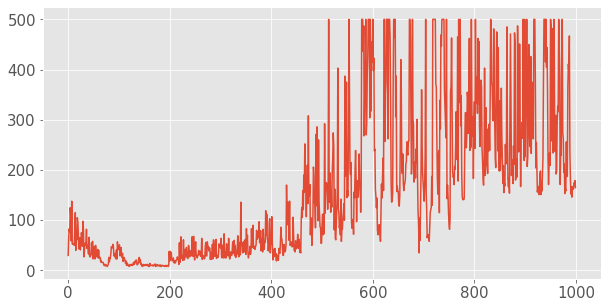

In [242]:
plt.plot(eps_steps)

In [243]:
%%time

buffer = 100
print(buffer, lr, seed)
np.random.seed(seed)

env_name = 'CartPole-v1'

eps_steps = []
env = gym.make(env_name)

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

100 0.001 0
num_episode: 1; terminal_step: 84
num_episode: 2; terminal_step: 54
num_episode: 3; terminal_step: 77
num_episode: 4; terminal_step: 148
num_episode: 5; terminal_step: 115
num_episode: 6; terminal_step: 52
num_episode: 7; terminal_step: 49
num_episode: 8; terminal_step: 39
num_episode: 9; terminal_step: 60
num_episode: 10; terminal_step: 78
num_episode: 11; terminal_step: 120
num_episode: 12; terminal_step: 58
num_episode: 13; terminal_step: 97
num_episode: 14; terminal_step: 59
num_episode: 15; terminal_step: 88
num_episode: 16; terminal_step: 99
num_episode: 17; terminal_step: 103
num_episode: 18; terminal_step: 60
num_episode: 19; terminal_step: 65
num_episode: 20; terminal_step: 36
num_episode: 21; terminal_step: 62
num_episode: 22; terminal_step: 34
num_episode: 23; terminal_step: 50
num_episode: 24; terminal_step: 45
num_episode: 25; terminal_step: 30
num_episode: 26; terminal_step: 39
num_episode: 27; terminal_step: 30
num_episode: 28; terminal_step: 48
num_episode: 

num_episode: 232; terminal_step: 15
num_episode: 233; terminal_step: 15
num_episode: 234; terminal_step: 83
num_episode: 235; terminal_step: 32
num_episode: 236; terminal_step: 55
num_episode: 237; terminal_step: 65
num_episode: 238; terminal_step: 59
num_episode: 239; terminal_step: 66
num_episode: 240; terminal_step: 39
num_episode: 241; terminal_step: 109
num_episode: 242; terminal_step: 61
num_episode: 243; terminal_step: 56
num_episode: 244; terminal_step: 36
num_episode: 245; terminal_step: 39
num_episode: 246; terminal_step: 43
num_episode: 247; terminal_step: 33
num_episode: 248; terminal_step: 33
num_episode: 249; terminal_step: 34
num_episode: 250; terminal_step: 31
num_episode: 251; terminal_step: 58
num_episode: 252; terminal_step: 47
num_episode: 253; terminal_step: 94
num_episode: 254; terminal_step: 27
num_episode: 255; terminal_step: 44
num_episode: 256; terminal_step: 65
num_episode: 257; terminal_step: 66
num_episode: 258; terminal_step: 79
num_episode: 259; terminal_

num_episode: 457; terminal_step: 500
num_episode: 458; terminal_step: 216
num_episode: 459; terminal_step: 205
num_episode: 460; terminal_step: 196
num_episode: 461; terminal_step: 198
num_episode: 462; terminal_step: 247
num_episode: 463; terminal_step: 398
num_episode: 464; terminal_step: 248
num_episode: 465; terminal_step: 348
num_episode: 466; terminal_step: 270
num_episode: 467; terminal_step: 274
num_episode: 468; terminal_step: 327
num_episode: 469; terminal_step: 180
num_episode: 470; terminal_step: 238
num_episode: 471; terminal_step: 186
num_episode: 472; terminal_step: 228
num_episode: 473; terminal_step: 277
num_episode: 474; terminal_step: 369
num_episode: 475; terminal_step: 381
num_episode: 476; terminal_step: 500
num_episode: 477; terminal_step: 275
num_episode: 478; terminal_step: 142
num_episode: 479; terminal_step: 161
num_episode: 480; terminal_step: 171
num_episode: 481; terminal_step: 377
num_episode: 482; terminal_step: 316
num_episode: 483; terminal_step: 260
n

num_episode: 679; terminal_step: 453
num_episode: 680; terminal_step: 412
num_episode: 681; terminal_step: 286
num_episode: 682; terminal_step: 316
num_episode: 683; terminal_step: 249
num_episode: 684; terminal_step: 288
num_episode: 685; terminal_step: 250
num_episode: 686; terminal_step: 190
num_episode: 687; terminal_step: 267
num_episode: 688; terminal_step: 389
num_episode: 689; terminal_step: 343
num_episode: 690; terminal_step: 244
num_episode: 691; terminal_step: 313
num_episode: 692; terminal_step: 393
num_episode: 693; terminal_step: 160
num_episode: 694; terminal_step: 291
num_episode: 695; terminal_step: 266
num_episode: 696; terminal_step: 415
num_episode: 697; terminal_step: 238
num_episode: 698; terminal_step: 500
num_episode: 699; terminal_step: 273
num_episode: 700; terminal_step: 500
num_episode: 701; terminal_step: 282
num_episode: 702; terminal_step: 256
num_episode: 703; terminal_step: 229
num_episode: 704; terminal_step: 313
num_episode: 705; terminal_step: 244
n

num_episode: 901; terminal_step: 188
num_episode: 902; terminal_step: 199
num_episode: 903; terminal_step: 192
num_episode: 904; terminal_step: 370
num_episode: 905; terminal_step: 453
num_episode: 906; terminal_step: 381
num_episode: 907; terminal_step: 204
num_episode: 908; terminal_step: 366
num_episode: 909; terminal_step: 438
num_episode: 910; terminal_step: 244
num_episode: 911; terminal_step: 500
num_episode: 912; terminal_step: 171
num_episode: 913; terminal_step: 154
num_episode: 914; terminal_step: 281
num_episode: 915; terminal_step: 313
num_episode: 916; terminal_step: 215
num_episode: 917; terminal_step: 138
num_episode: 918; terminal_step: 142
num_episode: 919; terminal_step: 170
num_episode: 920; terminal_step: 319
num_episode: 921; terminal_step: 247
num_episode: 922; terminal_step: 266
num_episode: 923; terminal_step: 296
num_episode: 924; terminal_step: 374
num_episode: 925; terminal_step: 224
num_episode: 926; terminal_step: 225
num_episode: 927; terminal_step: 332
n

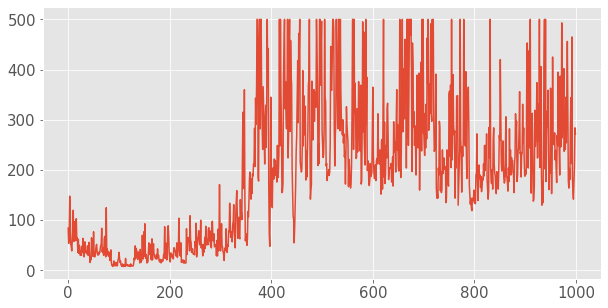

In [244]:
plt.plot(eps_steps)

### trying lunar lander

In [245]:
%%time

buffer = 50
print(buffer, lr, seed)
np.random.seed(seed)

env_name = 'LunarLander-v2'

eps_steps = []
env = gym.make(env_name)

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.001 0
num_episode: 1; terminal_step: 62
num_episode: 2; terminal_step: 58
num_episode: 3; terminal_step: 60
num_episode: 4; terminal_step: 82
num_episode: 5; terminal_step: 76
num_episode: 6; terminal_step: 60
num_episode: 7; terminal_step: 64
num_episode: 8; terminal_step: 54
num_episode: 9; terminal_step: 58
num_episode: 10; terminal_step: 55
num_episode: 11; terminal_step: 56
num_episode: 12; terminal_step: 74
num_episode: 13; terminal_step: 92
num_episode: 14; terminal_step: 74
num_episode: 15; terminal_step: 52
num_episode: 16; terminal_step: 57
num_episode: 17; terminal_step: 53
num_episode: 18; terminal_step: 51
num_episode: 19; terminal_step: 67
num_episode: 20; terminal_step: 71
num_episode: 21; terminal_step: 89
num_episode: 22; terminal_step: 79
num_episode: 23; terminal_step: 86
num_episode: 24; terminal_step: 60
num_episode: 25; terminal_step: 78
num_episode: 26; terminal_step: 96
num_episode: 27; terminal_step: 84
num_episode: 28; terminal_step: 82
num_episode: 29; t

num_episode: 232; terminal_step: 90
num_episode: 233; terminal_step: 127
num_episode: 234; terminal_step: 126
num_episode: 235; terminal_step: 97
num_episode: 236; terminal_step: 158
num_episode: 237; terminal_step: 168
num_episode: 238; terminal_step: 136
num_episode: 239; terminal_step: 113
num_episode: 240; terminal_step: 141
num_episode: 241; terminal_step: 80
num_episode: 242; terminal_step: 188
num_episode: 243; terminal_step: 162
num_episode: 244; terminal_step: 81
num_episode: 245; terminal_step: 256
num_episode: 246; terminal_step: 106
num_episode: 247; terminal_step: 143
num_episode: 248; terminal_step: 159
num_episode: 249; terminal_step: 121
num_episode: 250; terminal_step: 83
num_episode: 251; terminal_step: 112
num_episode: 252; terminal_step: 138
num_episode: 253; terminal_step: 124
num_episode: 254; terminal_step: 170
num_episode: 255; terminal_step: 145
num_episode: 256; terminal_step: 108
num_episode: 257; terminal_step: 186
num_episode: 258; terminal_step: 87
num_epi

num_episode: 459; terminal_step: 71
num_episode: 460; terminal_step: 53
num_episode: 461; terminal_step: 70
num_episode: 462; terminal_step: 62
num_episode: 463; terminal_step: 89
num_episode: 464; terminal_step: 65
num_episode: 465; terminal_step: 55
num_episode: 466; terminal_step: 68
num_episode: 467; terminal_step: 72
num_episode: 468; terminal_step: 59
num_episode: 469; terminal_step: 62
num_episode: 470; terminal_step: 68
num_episode: 471; terminal_step: 93
num_episode: 472; terminal_step: 91
num_episode: 473; terminal_step: 151
num_episode: 474; terminal_step: 251
num_episode: 475; terminal_step: 309
num_episode: 476; terminal_step: 242
num_episode: 477; terminal_step: 212
num_episode: 478; terminal_step: 305
num_episode: 479; terminal_step: 248
num_episode: 480; terminal_step: 96
num_episode: 481; terminal_step: 157
num_episode: 482; terminal_step: 53
num_episode: 483; terminal_step: 294
num_episode: 484; terminal_step: 216
num_episode: 485; terminal_step: 196
num_episode: 486;

num_episode: 682; terminal_step: 236
num_episode: 683; terminal_step: 252
num_episode: 684; terminal_step: 169
num_episode: 685; terminal_step: 98
num_episode: 686; terminal_step: 220
num_episode: 687; terminal_step: 89
num_episode: 688; terminal_step: 96
num_episode: 689; terminal_step: 216
num_episode: 690; terminal_step: 86
num_episode: 691; terminal_step: 170
num_episode: 692; terminal_step: 167
num_episode: 693; terminal_step: 305
num_episode: 694; terminal_step: 90
num_episode: 695; terminal_step: 158
num_episode: 696; terminal_step: 214
num_episode: 697; terminal_step: 172
num_episode: 698; terminal_step: 134
num_episode: 699; terminal_step: 216
num_episode: 700; terminal_step: 95
num_episode: 701; terminal_step: 213
num_episode: 702; terminal_step: 238
num_episode: 703; terminal_step: 199
num_episode: 704; terminal_step: 250
num_episode: 705; terminal_step: 195
num_episode: 706; terminal_step: 792
num_episode: 707; terminal_step: 332
num_episode: 708; terminal_step: 214
num_epi

num_episode: 904; terminal_step: 305
num_episode: 905; terminal_step: 272
num_episode: 906; terminal_step: 280
num_episode: 907; terminal_step: 298
num_episode: 908; terminal_step: 585
num_episode: 909; terminal_step: 243
num_episode: 910; terminal_step: 362
num_episode: 911; terminal_step: 398
num_episode: 912; terminal_step: 227
num_episode: 913; terminal_step: 348
num_episode: 914; terminal_step: 281
num_episode: 915; terminal_step: 194
num_episode: 916; terminal_step: 124
num_episode: 917; terminal_step: 87
num_episode: 918; terminal_step: 71
num_episode: 919; terminal_step: 199
num_episode: 920; terminal_step: 139
num_episode: 921; terminal_step: 90
num_episode: 922; terminal_step: 170
num_episode: 923; terminal_step: 104
num_episode: 924; terminal_step: 92
num_episode: 925; terminal_step: 81
num_episode: 926; terminal_step: 229
num_episode: 927; terminal_step: 382
num_episode: 928; terminal_step: 309
num_episode: 929; terminal_step: 158
num_episode: 930; terminal_step: 199
num_ep

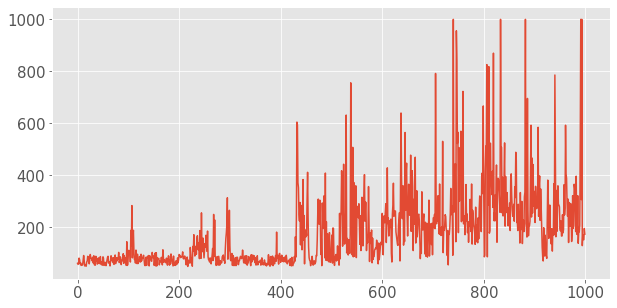

In [247]:
plt.plot(eps_steps)

In [252]:
%%time

buffer = 50
print(buffer, lr, seed)
np.random.seed(seed)

env_name = 'LunarLander-v2'

eps_steps = []
env = gym.make(env_name)

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_HER(terminal_reward=terminal_r_dict[env_name], buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    replay.reset_her()

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        replay.add_experience(s, a, r, s_next, terminal)
        replay.add_her_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    replay.modify_her_list()
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.001 0
num_episode: 1; terminal_step: 60
num_episode: 2; terminal_step: 60
num_episode: 3; terminal_step: 56
num_episode: 4; terminal_step: 70
num_episode: 5; terminal_step: 67
num_episode: 6; terminal_step: 86
num_episode: 7; terminal_step: 63
num_episode: 8; terminal_step: 74
num_episode: 9; terminal_step: 71
num_episode: 10; terminal_step: 68
num_episode: 11; terminal_step: 69
num_episode: 12; terminal_step: 62
num_episode: 13; terminal_step: 61
num_episode: 14; terminal_step: 65
num_episode: 15; terminal_step: 67
num_episode: 16; terminal_step: 66
num_episode: 17; terminal_step: 83
num_episode: 18; terminal_step: 67
num_episode: 19; terminal_step: 49
num_episode: 20; terminal_step: 82
num_episode: 21; terminal_step: 62
num_episode: 22; terminal_step: 60
num_episode: 23; terminal_step: 81
num_episode: 24; terminal_step: 82
num_episode: 25; terminal_step: 55
num_episode: 26; terminal_step: 62
num_episode: 27; terminal_step: 87
num_episode: 28; terminal_step: 83
num_episode: 29; t

num_episode: 230; terminal_step: 165
num_episode: 231; terminal_step: 226
num_episode: 232; terminal_step: 171
num_episode: 233; terminal_step: 160
num_episode: 234; terminal_step: 71
num_episode: 235; terminal_step: 165
num_episode: 236; terminal_step: 124
num_episode: 237; terminal_step: 127
num_episode: 238; terminal_step: 175
num_episode: 239; terminal_step: 83
num_episode: 240; terminal_step: 101
num_episode: 241; terminal_step: 89
num_episode: 242; terminal_step: 72
num_episode: 243; terminal_step: 148
num_episode: 244; terminal_step: 86
num_episode: 245; terminal_step: 118
num_episode: 246; terminal_step: 77
num_episode: 247; terminal_step: 172
num_episode: 248; terminal_step: 106
num_episode: 249; terminal_step: 76
num_episode: 250; terminal_step: 235
num_episode: 251; terminal_step: 95
num_episode: 252; terminal_step: 89
num_episode: 253; terminal_step: 72
num_episode: 254; terminal_step: 315
num_episode: 255; terminal_step: 91
num_episode: 256; terminal_step: 80
num_episode: 

num_episode: 457; terminal_step: 122
num_episode: 458; terminal_step: 87
num_episode: 459; terminal_step: 91
num_episode: 460; terminal_step: 93
num_episode: 461; terminal_step: 92
num_episode: 462; terminal_step: 118
num_episode: 463; terminal_step: 101
num_episode: 464; terminal_step: 103
num_episode: 465; terminal_step: 97
num_episode: 466; terminal_step: 84
num_episode: 467; terminal_step: 114
num_episode: 468; terminal_step: 81
num_episode: 469; terminal_step: 86
num_episode: 470; terminal_step: 76
num_episode: 471; terminal_step: 81
num_episode: 472; terminal_step: 115
num_episode: 473; terminal_step: 116
num_episode: 474; terminal_step: 71
num_episode: 475; terminal_step: 89
num_episode: 476; terminal_step: 144
num_episode: 477; terminal_step: 87
num_episode: 478; terminal_step: 119
num_episode: 479; terminal_step: 123
num_episode: 480; terminal_step: 85
num_episode: 481; terminal_step: 84
num_episode: 482; terminal_step: 81
num_episode: 483; terminal_step: 89
num_episode: 484; 

num_episode: 684; terminal_step: 86
num_episode: 685; terminal_step: 83
num_episode: 686; terminal_step: 75
num_episode: 687; terminal_step: 90
num_episode: 688; terminal_step: 81
num_episode: 689; terminal_step: 97
num_episode: 690; terminal_step: 85
num_episode: 691; terminal_step: 70
num_episode: 692; terminal_step: 72
num_episode: 693; terminal_step: 73
num_episode: 694; terminal_step: 67
num_episode: 695; terminal_step: 112
num_episode: 696; terminal_step: 91
num_episode: 697; terminal_step: 92
num_episode: 698; terminal_step: 78
num_episode: 699; terminal_step: 78
num_episode: 700; terminal_step: 101
num_episode: 701; terminal_step: 80
num_episode: 702; terminal_step: 110
num_episode: 703; terminal_step: 106
num_episode: 704; terminal_step: 70
num_episode: 705; terminal_step: 94
num_episode: 706; terminal_step: 96
num_episode: 707; terminal_step: 92
num_episode: 708; terminal_step: 100
num_episode: 709; terminal_step: 79
num_episode: 710; terminal_step: 115
num_episode: 711; term

num_episode: 910; terminal_step: 97
num_episode: 911; terminal_step: 148
num_episode: 912; terminal_step: 91
num_episode: 913; terminal_step: 129
num_episode: 914; terminal_step: 117
num_episode: 915; terminal_step: 127
num_episode: 916; terminal_step: 115
num_episode: 917; terminal_step: 122
num_episode: 918; terminal_step: 151
num_episode: 919; terminal_step: 130
num_episode: 920; terminal_step: 125
num_episode: 921; terminal_step: 139
num_episode: 922; terminal_step: 110
num_episode: 923; terminal_step: 112
num_episode: 924; terminal_step: 100
num_episode: 925; terminal_step: 95
num_episode: 926; terminal_step: 117
num_episode: 927; terminal_step: 164
num_episode: 928; terminal_step: 149
num_episode: 929; terminal_step: 90
num_episode: 930; terminal_step: 103
num_episode: 931; terminal_step: 94
num_episode: 932; terminal_step: 109
num_episode: 933; terminal_step: 114
num_episode: 934; terminal_step: 124
num_episode: 935; terminal_step: 108
num_episode: 936; terminal_step: 107
num_ep

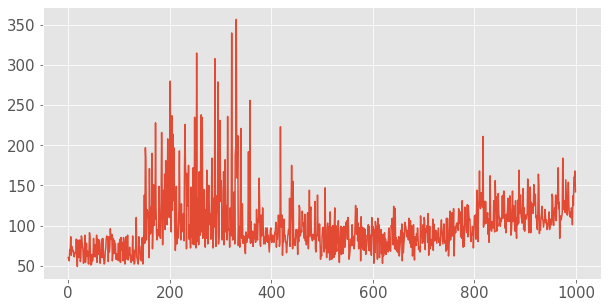

In [253]:
plt.plot(eps_steps)

### trying centipede ram

In [215]:
%%time

print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('Centipede-ram-v0')

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    
#     print(s)

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
#         print(a)
        
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
            
#         print(r)
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.001 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
100.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
100.0
0.0
0.0
100.0
0.0
0.0
0.0
0.0
100.0
0.0
100.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.0
0.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
0.0
5.0
0.0
5.0
0.0
0.0
0.0
5.0
0.0
0.0


KeyboardInterrupt: 

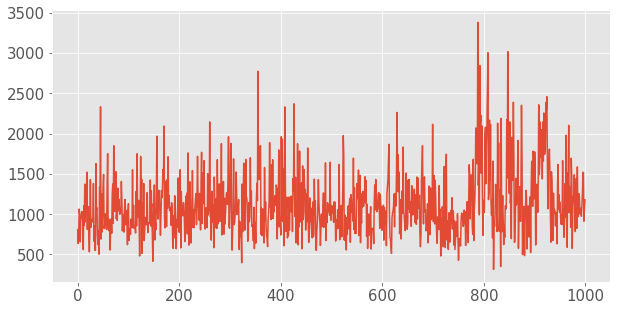

In [188]:
plt.plot(eps_steps)

In [216]:
%%time

print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('LunarLander-v2')

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    
#     print(s)

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
#         print(a)
        
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
            
        print(r)
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.001 0
-0.2877014862336853
-0.660707061714702
-0.8568066110363464
-1.1467730365352782
-1.3602337580612118
-1.6950864502460081
-1.7627984714904972
-2.2006424569507588
-2.7402292323397988
-2.574717044877103
-2.875836496129635
-3.5599314222783947
-2.5104813421858125
-5.069527160140399
-1.4182367447745878
-3.7953405938119134
-4.056504677451897
-3.9912374920662033
-4.702815208578101
-4.941114419792853
-5.227858157637086
-5.099743862862765
-5.3817944311100225
-5.936448469033876
-6.05363878425507
-6.331125581892109
-6.690626009338387
-6.532825132118574
-7.105058315299941
-7.1284768234753235
-7.4610199177777465
-7.443990441513079
-6.784157160917971
-7.803888984597591
-7.9698119789299815
-8.00020053351457
-8.30199970980547
-8.687112231705639
-8.69052010501454
-9.055030814434557
-8.94525469402643
-9.213476175021894
-9.258905032995669
-9.462834937762663
-9.780794309234492
-10.014822057002815
-10.126103056357492
-10.30216562849162
-10.432987787899291
-10.432967406973175
-10.581478396458833
-10

-1.0405634212989412
0.019824525750807426
1.3215390913095575
-0.9877384106459886
-1.0045631513730484
-1.018253423407856
-1.0280427437475623
-1.0340647425849454
-1.0365421733730784
-1.0356512688403257
-1.0315710440984276
-1.0244592462747164
-2.0529674874241537
-2.043026013386536
-2.428490070516743
-1.5458770034147733
-2.3276638909784126
-0.9471920998880978
-0.7732330720741334
-0.3721105953971733
0.08729359127904673
-0.1531539636775949
-0.02575297223222492
0.23982111874059456
0.2328497943290995
0.7226153039444807
0.8438086002036311
0.962116503336149
1.110471471409569
1.3300355911955262
-0.042684045238358975
1.5463607390508127
0.1242904452811058
1.2935845954813499
1.6495430121445633
0.4369538233733874
0.31870175999878936
0.12831556250185486
-0.06827245765069165
-0.19667844665988696
-0.4015767541754929
-0.7167670116361353
-0.8360097962230089
-1.1895840782420908
-1.109741838655366
-1.6364578641739616
-1.8282734579243243
-1.9115416424756677
-2.186856739296387
-2.43944156275512
-2.858010268999

-0.33724961823375565
-0.5422238771737682
-0.6987404930905257
-0.8453036914683025
-0.9790354886540058
-1.0979172764134262
-1.2009562325265222
-1.2880241996059567
-1.3596149111559725
-1.4167023117353779
-1.4604565919538004
-1.4921844644973703
-1.513220909012233
-1.5248025104650367
-1.528111721556627
-1.5241970620282643
-1.513949497631188
-0.8250619533999941
-1.3089422207040684
-1.2831828548615931
-1.2538887677012838
-1.2215157309697133
-1.1864926127984745
-0.6179535841048949
-1.0353876818995502
-0.9119666347988016
-0.8686331251308275
-0.22067117829968083
-0.5884896081089721
-0.5411265875372635
-0.49299043376896634
-0.4441564794213946
-0.39474429390782007
-0.3448547313697645
-0.29456939080992584
-0.8587521008274155
4.625999489568312
-0.5232294770672183
0.046064768581602494
0.23818125715149677
0.40775538372659637
0.7302560806633107
0.8677810123788572
1.1822685247751974
1.2911178959294045
0.5129663346524762
-1.6017097678892458
-1.7539818606138045
-1.6971584185551467
-1.5849494538229851
-1.8

1.3939962918247204
1.4808421203652529
1.4892653482091305
1.4807121636800673
1.4555247663436433
1.408648660596299
1.3337349527617732
1.2231853314432044
1.068525187360649
0.8621413366978743
0.6003619267445686
0.2877255721563188
-0.059616329949534475
-0.415475779261385
-0.7508516681747892
-1.043207941006557
-1.281534031316312
-1.4652739821230796
-1.6002627270824803
-1.6947434125228824
-1.7569836905544776
-1.7940301322596213
-1.811615156616
-1.8141748274326517
-1.8842668378395615
-1.785853992015177
-1.7603356228426037
-1.7291886109251493
-1.6935387838499594
-1.6542981088596775
-1.6120995231152904
-1.5674781685727055
-1.5208979257539
-1.4726329378863738
-0.9388591298059044
-1.1647789634691605
-1.1121066600893244
-1.0586964301255932
-1.004643637029119
-0.9500702483255168
-0.4399968941772261
-0.2134380055189797
0.11130845755028076
0.27921472611433384
0.4575082893166791
0.8263924844903283
0.34988353665252814
-0.5787308239607956
-1.9838609874115878
-2.1773200209352397
-2.22226201195994
-2.40951

0.867860727813395
1.068852176883497
1.6103840987307774
-1.9610314130785185
1.671224641389274
1.8373070084780079
2.1223922779056763
1.5299946437849326
-0.7396182144724139
0.711338427474318
0.768589740292499
0.6193541716371567
-1.8076720630934233
-1.1829739428588641
0.3450792857595115
-3.1807494945826305
0.06477930894740894
-0.5556335994124482
-1.7918183696441645
-3.169626770984922
-2.3507703831311515
-0.8471635974441825
-0.7139105349040336
-0.04903040173779799
-3.317957275678185
-3.0355743209277533
-0.7393461663999108
0.8335259908979833
-0.6256939938088226
-0.16284155306950082
-1.139302118237697
-0.5186062129470475
1.1068176951226303
-2.2510766949329364
-0.693225336375831
0.9298834593919605
0.15275520678796967
-0.43716523342558733
1.0934686128395026
-0.1465761235446223
-0.33444600429777327
1.5503094800686312
-1.5098325242238275
-0.2606377733967406
0.0733267945450973
-1.4335977535100313
-1.567832316830237
0.841613707103819
0.7091153721850116
1.9960838768923292
0.48985814169587344
0.94344

0.7804767910065789
0.8803083362183781
1.1029156458662908
1.4555825042106971
1.8278118106727856
1.5713071420120752
2.036749138231103
0.7018568446652023
-0.9391789885060178
0.07655760045329998
-0.043756726045841104
-1.0893684767959428
-0.6175402666428511
-2.3420385976655096
-2.6113452401725565
-1.3352419905017314
0.21222870846713818
-1.457924903799493
-1.8428650389745542
-3.569315101703455
-1.1731445424504898
-0.10783604825471002
-0.8373108076256699
-1.6610418477412157
-0.21502952190245422
-0.7444282655542793
0.16399327533168845
-1.2730753340268268
-1.3907552317726755
-1.0286482704691082
-0.03215524656251317
-1.7393870279829458
-1.7043241760692809
-0.5093066716102885
0.28837940784453053
0.22593537354813975
0.1520647414670293
0.06662956000289455
-0.9125818450167731
0.08338672791234103
-0.028050256114653394
-0.14639948204450093
-0.26952556136373573
-0.3949918059742572
-0.5202232356436127
0.13121154706394236
-1.8660080080678643
-1.599747852082969
-0.7424674249057261
-0.8318121945247299
-0.9

2.0619855190277305
2.3702667724533923
2.1192808285832725
1.843291186025483
0.12453491432805322
1.2958781342423447
-0.48977731134721014
0.7016862164810231
-1.6930864838459445
-0.6027256296559347
-2.2991360680261423
-1.1706080790780777
-2.6451311955997014
-1.802263549022739
-2.8056608039806563
-1.9970864596697868
-2.8701658241019445
-2.1951419146016335
-2.43856488809743
-2.7234672396714914
-2.385862662049702
-2.6492479367896338
-2.410083531794412
-2.6276951352647857
-2.4496868463232304
-2.405089568557939
-2.3761965961994904
-2.2773769197569025
-2.354922672655873
-2.2248195907395982
-1.984795460723176
-2.0694865311898796
-1.8669245595101518
-1.5392187364045344
-1.6695116782293258
-1.4688374150038033
-1.5942152626098778
-1.2204020419389099
-1.3359664509281106
-1.1308644468099647
-0.8050172923164769
-1.0227072648708304
-0.7285482008949191
-0.8561729929475053
-0.47638268035879494
-0.8252492740490129
-0.47926400720038376
-0.29215599674580406
-0.4786644850682922
-0.0929964780193859
-0.37986154

1.62504608817875
0.6223741168659853
-0.8671823323406318
-0.4499210529357913
-1.6052142440637158
-3.0665550911762396
-3.235055790891663
-2.287449053034662
2.159891535017022
-3.182060354373759
-2.4111972737172764
-3.1201939127660965
-2.3798246285631692
-2.922450799217414
-2.3502484807767687
-2.7033275004256994
-2.2699184605332605
-2.6630475920824197
-2.113365342514355
-2.5472002056191614
-2.0792262361032656
-2.5102081285560005
-2.064284188727241
-2.4127096742466265
-1.9233485516953397
-2.1737256887761007
-1.700901039529383
-2.1600424514891174
-1.6478728053564555
-1.3460039742640209
-1.7815654295326613
-1.185509244120566
-0.9669452734334516
-1.3339518485803683
-0.8800536070141323
-1.1228608842897632
-0.6408761474963558
-0.49896855001955376
-0.2353913229449904
-0.4586133593637942
-0.13993687818859143
0.15244106177462527
-0.08116402632287986
0.28435119706102907
-0.01971095457090996
0.4580806986739685
0.5868801439479239
0.3272620722897852
0.6952945377451567
0.9592265468981804
1.2313274219911

-5.205160442738388
-5.679156172080439
-6.149414929294294
-6.633170947975969
-7.116220274022367
2.230043425522156
112.11611096855401
-19.754344190797696
-18.628915326308174
-20.41179952257471
-18.774818912840516
-18.36447728658885
-28.804984182023844
100
num_episode: 48; terminal_step: 88
0.27126795039586793
0.448496404882037
0.4585182258057625
0.63866432685066
0.7542789297274635
1.0650029244017685
1.0497122816855449
-0.6503414408668107
-0.5333854828385529
-1.0337573304058754
-1.6899772999393292
-1.2732776443131957
-1.2969952206744029
-1.591667426534342
-2.794999860411336
-1.8068702057518624
-2.7262230559275893
-1.7233607870298886
-1.8762376274451913
-2.7861577955545997
-1.7731964148803445
-2.52654380140646
-1.7392779445285942
-1.8630317154385512
-2.659008605904289
-1.9766868886465818
-2.1842796498098664
-2.0162546591822363
-2.254685176596324
-2.6937395939804376
-2.1838829888147573
-2.4560866603497105
-2.6190128289503307
0.3731980348021125
-2.8213448985591456
-2.7641802782966622
-2.6757

5.1397772169229095
5.284305753904875
-2.138849796147069
-5.756745427436214
-6.171319860527489
-6.29949253899025
-6.911134523847237
-7.222433292835233
-7.844075361423648
-8.391446814280213
-8.903817746641748
0.28307594508501777
11.299626632529483
100
num_episode: 55; terminal_step: 91
0.2924552285967945
0.47304603357506037
0.40464888042771574
-1.5766719666314362
0.520506660384741
1.9851343942377297
-1.6270321379095936
0.4637425285600625
-1.7230376191988614
-1.8262328123094267
-0.143490912011315
0.13818404783757046
-1.730246440462962
-2.23460897330031
-0.3691545007907837
0.051554490512758094
-1.7051288731388456
0.01827777428522495
-0.8129971564015364
-1.7822264938813805
-0.22912517761599702
-1.7816136399073048
-0.2295687495039249
-0.15706899019090656
-1.4116987595966737
-0.1509323451036255
-0.574316713210294
0.23471513558504967
-1.1411027124475186
0.2643008024564619
0.30355082891861795
0.4587596707851287
-0.4472054170744275
-0.45144562894995377
-1.073878580177875
-1.1153709058993104
-1.6

1.3659286637570471
1.7129133513684291
1.8042600285928085
1.9476450546392254
1.5603712004498516
0.7660561552539786
0.5319123743912837
0.389717961296584
-0.21942573726999967
-0.5570312466510063
-0.9512132104016178
-1.0967435365027416
-1.4438358744598634
-2.100388909523757
-2.5617305989983365
-2.762376068520011
-3.432326978287931
-3.7633343272956084
-4.365449257002524
-4.136971190541344
-4.5245651137857115
-4.836641745389925
-5.243032856085306
-5.453910400653938
-5.81265907700208
-5.982530848022178
-1.6962522362916446
-5.781168512993474
-6.171773922433828
-5.5681064763173245
-5.386210333096897
-5.023847277026362
-4.6885693591530915
-0.9275669468477077
-4.409149399313065
-2.2138110902046604
-3.96812493731599
-3.7310555735433852
-3.3954816330345055
-3.2337198528528845
-2.8698246902380604
-2.705606978237283
-2.4256119380403036
-1.8505586234481075
-1.5336097215254358
-1.3480170217825094
-0.9017100325286538
-0.7894766337729766
-0.5336049194957855
-0.039033993701791586
0.03631195488745334
0.570

0.4695648023857768
-1.3000868277901703
0.512023320006308
0.6146199642074361
-1.3865912579507256
0.6887203484879489
0.7290491679606543
1.0492542734668018
1.2763382803836134
1.146906437072489
0.1848008995837074
-0.7921677687650959
-1.035392145796236
-1.5374494480921317
-1.625055767590054
-1.9397078447483398
-2.204152843815932
-2.39251146830034
-2.7983785198224767
-0.607019051302234
-2.9345351107772317
-3.10469007405993
-3.5200256160351544
-3.7670701298097797
-3.999521345940933
-4.262550264914551
-4.524678388550085
0.17400437614965086
-4.83746641385656
-4.916067777721651
-5.08187975814863
-5.329975744081962
-5.572935438450229
-5.12511200174461
-5.598851274427743
-4.894903070079152
-4.527714211755636
-4.136464381561068
-4.999814921938337
-4.142213165397918
-3.871163176526436
-3.5133009020705956
-3.208813165006488
-2.904135176022207
-2.610541964566862
-2.5090541917856215
-2.048852261164909
-1.878927743710874
-1.4614712893935848
-1.2819390533298065
-1.1629592635157724
2.4071165467230005
-0.7

KeyboardInterrupt: 